In [22]:
from game_of_life import Game_of_life
from autoencoder import ConvolutionalAutoencoder
from fullycon import CullyConnCoder

import torch.nn as nn
import torch
import tqdm
import torch.optim as optim

%load_ext autoreload
%autoreload 2

SIZE=16
SIM_BATHC = 8

def generate_batch(batch_size, size, sims=SIM_BATHC):
    with torch.no_grad():
        game = Game_of_life(size)
        # game.cuda()
        # random binary noise of size size x size
        prev_batch = torch.randint(0, 2, (batch_size, 1, size, size))
        # prev_batch.cuda()
        batch = game(prev_batch)
        for i in range(sims):
            batch, prev_batch = game(batch), batch

        # return torch.nn.functional.one_hot(prev_batch.long(), 2).float(), torch.nn.functional.one_hot(batch.long(), 2).float()
        
        return prev_batch, batch 


def train_model(epochs, lr):
    # Use the ResNet18 when implemented
    # net = ConvolutionalAutoencoder(SIZE)
    net = CullyConnCoder(SIZE)
    # net.cuda()

    # Define the loss function
    criterion = nn.BCELoss(reduction='mean') 
    # criterion = nn.MSELoss()
    # criterion = nn.CrossEntropyLoss()
    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr)

    losses = []
    # loss_ra = 0
    for epoch in range(epochs):
        # Get the inputs; Data is a tuple of (images, labels)
        inputs, labels = generate_batch(1000, SIZE, SIM_BATHC)

        # Clear the saved gradients of the previous iteration
        optimizer.zero_grad()

        outputs = net(inputs)
        # print(torch.min(outputs[0]), torch.max(outputs[0]))
        
        # # Calculate the loss value
        loss = criterion(outputs.float(), inputs.float())
        losses.append(loss.data.cpu().detach().numpy())

        # # Calculate the gradients using backpropagation
        loss.backward()
        # loss_ra += loss.data.cpu().detach().numpy()
        # # Update the weights of the network using the chosen optimizer
        optimizer.step()
        if epoch % 50 == 0:
            print(loss.data.cpu().detach().numpy())


        if (epoch % 100) == 0:
            print(torch.sum(outputs[0] - labels[0]))
            print(loss.data.cpu().detach().numpy())

    # net.eval()
    # test_bird_model(net,testloader)
    
    return net, losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import matplotlib.pyplot as plt
# torch.cuda.empty_cache()

net,losses = train_model(8000, 0.005)
# prosim delaj



RuntimeError: all elements of input should be between 0 and 1

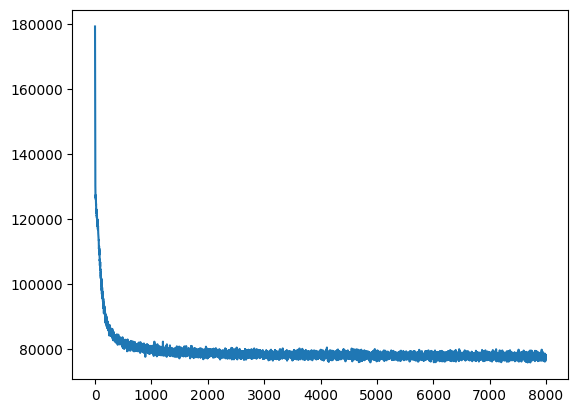

In [ ]:
plt.plot(losses)
plt.show()

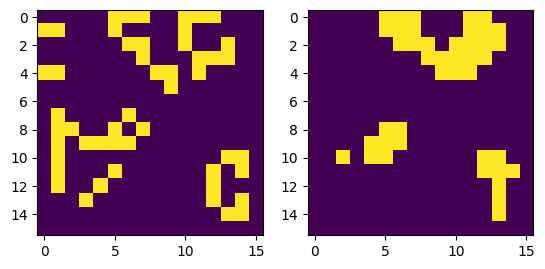

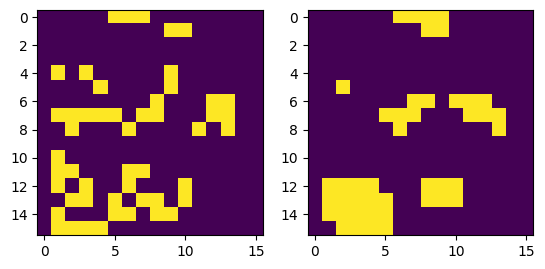

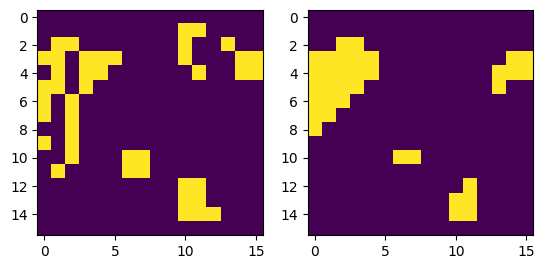

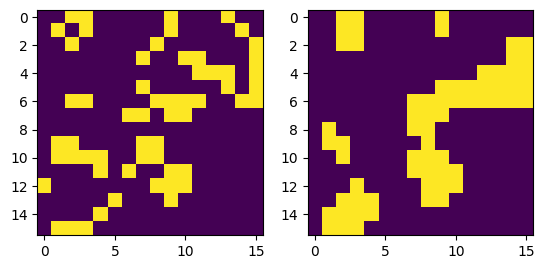

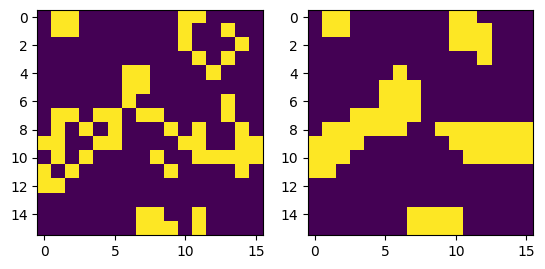

In [ ]:
#RANDOM TRIES
batch, next= generate_batch(5, SIZE, SIM_BATHC)
out = net(batch).cpu().detach().numpy()
out = out > 0.4
ba = batch.cpu().detach().numpy()

for i in range(5):
    ins = ba[i][0]
    res = out[i][0]
    fix, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ins)
    ax2.imshow(res)


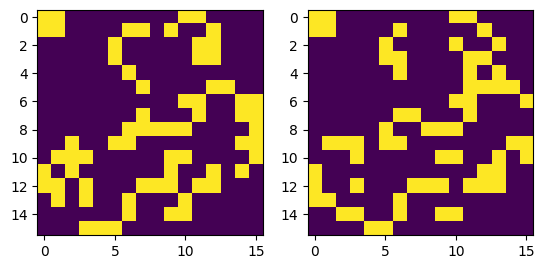

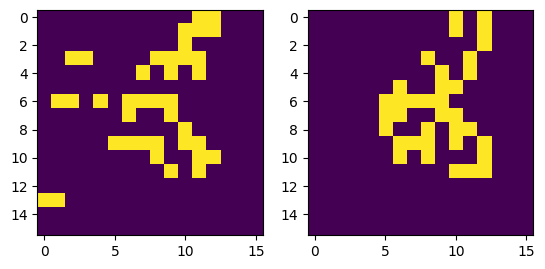

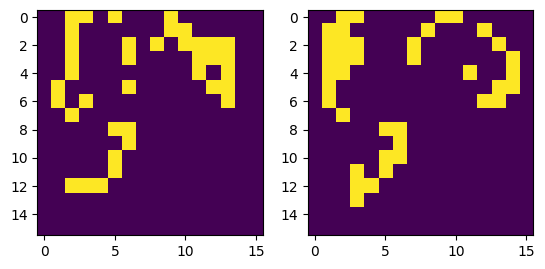

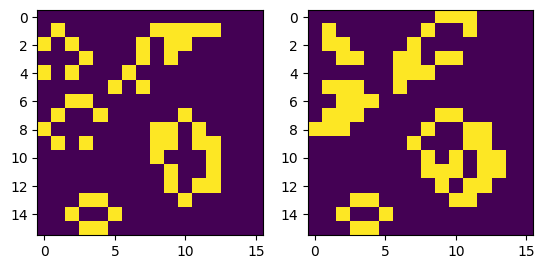

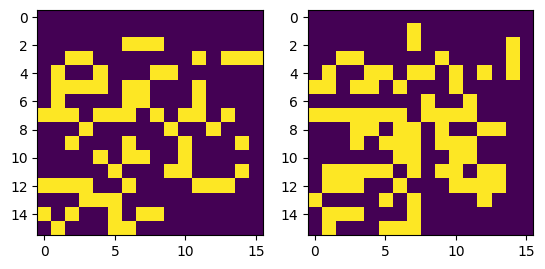

In [ ]:
out = generate_batch(5, SIZE, 8)
for i in range(5):
    ins = out[0][i][0].cpu().detach().numpy()
    res = out[1][i][0].cpu().detach().numpy()
    fix, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ins)
    ax2.imshow(res)

# Export onnx model

In [ ]:
out = generate_batch(5, SIZE, 8)
batch, next= generate_batch(5, SIZE, SIM_BATHC)
onnx_program = torch.onnx.dynamo_export(net, batch)

onnx_program.save("GOL_model.onnx")